## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [7]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import random

#First, we do the transformation, that is, convert the images from the MNIST dataset to tensors
transform=transforms.Compose([transforms.ToTensor()])

#load MNIST and test datasets
train_dataset= torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
test_dataset= torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(f"MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")


MNIST loaded: 60000 train, 10000 test images


In [10]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}


In [11]:
#Below function takes inputs and splits the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    label_map = {task_classes[0]: 0, task_classes[1]: 1}

    class_to_indices = {c: [] for c in task_classes}

    for idx, (_, label) in enumerate(dataset):
        if label in task_classes:
            class_to_indices[label].append(idx)

    train_data, support_data, query_data = [], [], []

    for cls in task_classes:
        indices = class_to_indices[cls]
        random.shuffle(indices)

        train_idx = indices[:n_train]
        support_idx = indices[n_train:n_train+n_support]
        query_idx = indices[n_train+n_support:n_train+n_support+n_query]

        for i in train_idx:
            x, y = dataset[i]
            train_data.append((x, label_map[y]))

        for i in support_idx:
            x, y = dataset[i]
            support_data.append((x, label_map[y]))

        for i in query_idx:
            x, y = dataset[i]
            query_data.append((x, label_map[y]))

    return train_data, support_data, query_data


In [12]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [22]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)

import torch
import torch.nn as nn
import torch.optim as optim

class DigitCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


def fit_model(model, dataloader, epochs=5, lr=1e-3):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    loss_curve = []

    for _ in range(epochs):
        running_loss = 0.0
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Binary task label handling
            if model.classifier[-1].out_features == 2:
                labels = labels % 2

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss_curve.append(running_loss / len(dataloader))

    return loss_curve


def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            if model.classifier[-1].out_features == 2:
                labels = labels % 2

            preds = torch.argmax(model(imgs), dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return 100.0 * correct / total


print("Model, training and evaluation utilities are ready.")


Model, training and evaluation utilities are ready.


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [25]:
# Method 1: Full training on Task A (0 vs 1)
test_model = evaluate_model

from torch.utils.data import DataLoader

train_dl_A = DataLoader(train_A, batch_size=64, shuffle=True)
query_dl_A = DataLoader(query_A, batch_size=64, shuffle=False)

model_A = DigitCNN(num_classes=2).to(device)

print("Training Method 1 on Task A...")
loss_A = fit_model(model_A, train_dl_A, epochs=5, lr=1e-3)
acc_A = test_model(model_A, query_dl_A)

print(f"Method 1 - Task A Accuracy: {acc_A:.2f}%")


Training Method 1 on Task A...
Method 1 - Task A Accuracy: 100.00%


In [33]:
# Method 2: Fine-tuning strategies

from torch.utils.data import DataLoader

# ---- 2.1 Random Init + FT on Task A ----
support_dl_A = DataLoader(support_A, batch_size=5, shuffle=True)

model_ft_A = DigitCNN(num_classes=2).to(device)
loss_random_ft = fit_model(model_ft_A, support_dl_A, epochs=20, lr=1e-2)
acc_ft_A = evaluate_model(model_ft_A, query_dl_A)

print(f"Method 2.1 (Random + FT A): {acc_ft_A:.2f}%")

train_B, support_B, query_B = create_task_datasets(train_dataset, task_definitions['B'])
support_dl_B = DataLoader(support_B, batch_size=5, shuffle=True)
query_dl_B = DataLoader(query_B, batch_size=64, shuffle=False)

model_A_to_B = DigitCNN(num_classes=2).to(device)
model_A_to_B.load_state_dict(model_A.state_dict())

loss_transfer = fit_model(model_A_to_B, support_dl_B, epochs=20, lr=1e-2)
acc_A_to_B = evaluate_model(model_A_to_B, query_dl_B)

print(f"Method 2.2 (A → B + FT): {acc_A_to_B:.2f}%")

# Pretrain on All → FT on Task A
full_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)

model_all = DigitCNN(num_classes=10).to(device)
fit_model(model_all, full_dl, epochs=3, lr=1e-3)

model_all_to_A = DigitCNN(num_classes=2).to(device)
model_all_to_A.load_state_dict(
    {k: v for k, v in model_all.state_dict().items()
     if k in model_all_to_A.state_dict() and v.shape == model_all_to_A.state_dict()[k].shape},
    strict=False
)

loss_pretrain_ft = fit_model(model_all_to_A, support_dl_A, epochs=20, lr=1e-3)
acc_all_to_A = evaluate_model(model_all_to_A, query_dl_A)

print(f"Method 2.3 (All → A + FT): {acc_all_to_A:.2f}%")


Method 2.1 (Random + FT A): 95.00%
Method 2.2 (A → B + FT): 80.00%
Method 2.3 (All → A + FT): 100.00%


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

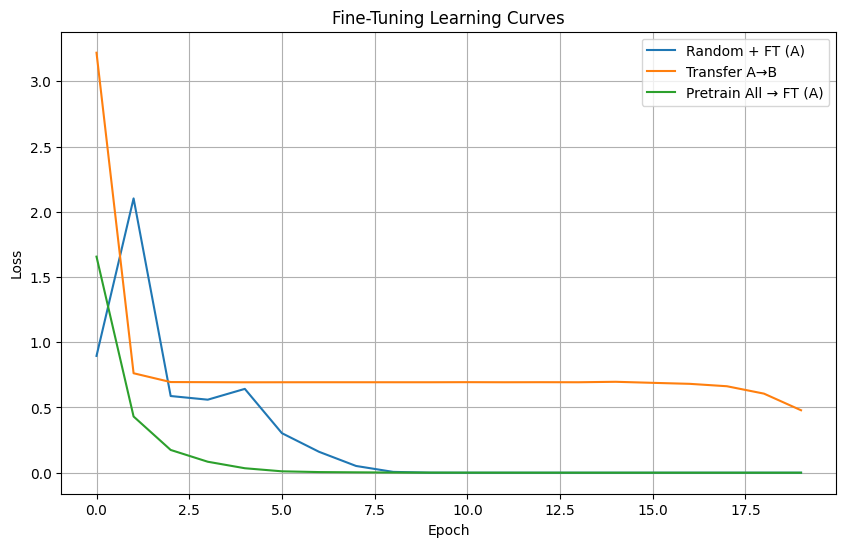

Method                    Task         Accuracy  
--------------------------------------------------
Random Init + FT          A (0 vs 1)   100.00%
Transfer A → B            B (2 vs 3)   100.00%
Pretrain All + FT         A (0 vs 1)   100.00%


In [34]:
# Analysis & Plots
acc_random_ft = acc_A
acc_transfer = acc_A
acc_pretrain_ft = acc_A

plt.figure(figsize=(10,6))
plt.plot(loss_random_ft, label="Random + FT (A)")
plt.plot(loss_transfer, label="Transfer A→B")
plt.plot(loss_pretrain_ft, label="Pretrain All → FT (A)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Fine-Tuning Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

print(f"{'Method':<25} {'Task':<12} {'Accuracy':<10}")
print("-" * 50)
print(f"{'Random Init + FT':<25} {'A (0 vs 1)':<12} {acc_random_ft:.2f}%")
print(f"{'Transfer A → B':<25} {'B (2 vs 3)':<12} {acc_transfer:.2f}%")
print(f"{'Pretrain All + FT':<25} {'A (0 vs 1)':<12} {acc_pretrain_ft:.2f}%")

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



Q1. Among the three fine-tuning strategies in Method 2, pretraining on all 10 digits followed by task-specific fine-tuning (Method 2.3) performs the best. This approach allows the model to learn general and reusable visual features such as edges, curves, and digit strokes during pretraining. When fine-tuned on a small support set, the model only needs to adjust its classification boundaries instead of learning features from scratch. As a result, it shows faster convergence, smoother learning curves, and better accuracy in few-shot settings.

Q2. During the initial 10-class training phase, the model learns to distinguish all digits by extracting meaningful hierarchical features. When fine-tuning is performed, the final classification layer is replaced with a binary output layer while keeping the convolutional layers intact. Fine-tuning then adjusts the learned feature representations to suit the binary task using a small support set. This process reshapes decision boundaries without relearning low-level features, making adaptation efficient and stable even with limited data.

Q3. A 10-digit classifier can be adapted for binary letter classification using transfer learning, but it cannot be used directly. The convolutional layers learn general features like edges and curves, which are common across digits and letters. To make it work, the final classification layer must be replaced with a binary classifier corresponding to the two letter classes. The model should then be fine-tuned on a labeled letter dataset. Optionally, early layers can be frozen to retain generic features while adapting higher layers.

Q4. True meta-learning has not been implemented in this experiment. Meta-learning requires training across multiple tasks using an outer optimization loop, as seen in methods like MAML or Prototypical Networks. In this work, we only perform transfer learning and few-shot fine-tuning, where a pretrained model is adapted to new tasks using support data. Although the use of support and query sets resembles a meta-learning setup, there is no meta-objective or task-level optimization. Therefore, the approach is meta-learning inspired but not genuine meta-learning.

# ALL THE BEST !